# Train object detection model with annotations and images from EXACT

## Imports 

#### Import error

If import fails clone both repos and add them to sys path:

```
!pip install object-detection-fastai
```

In [66]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
from exact_sync.v1.api.annotations_api import AnnotationsApi
from exact_sync.v1.api.images_api import ImagesApi
from exact_sync.v1.api.image_sets_api import ImageSetsApi
from exact_sync.v1.api.annotation_types_api import AnnotationTypesApi

In [12]:
from exact_sync.v1.models import ImageSet, Team, Product, AnnotationType, Image, Annotation, AnnotationMediaFile
from exact_sync.v1.rest import ApiException
from exact_sync.v1.configuration import Configuration
from exact_sync.v1.api_client import ApiClient

In [25]:
import os
from pathlib import Path
from tqdm import tqdm

## Train EXACT

### Set user name, password and server address

Load from file for production

In [21]:
configuration = Configuration()
configuration.username = 'exact'
configuration.password = 'exact'
configuration.host = "http://127.0.0.1:8000"

client = ApiClient(configuration)

image_sets_api = ImageSetsApi(client)
annotations_api = AnnotationsApi(client)
annotation_types_api = AnnotationTypesApi(client)
images_api = ImagesApi(client)


target_folder = Path('examples/images/') 

In [14]:
# Name of the data-sets to download images and annotations from
training_dataset_name = 'IconArt'
os.makedirs(str(target_folder), exist_ok=True)

In [20]:
image_sets = image_sets_api.list_image_sets(name__contains=training_dataset_name)
image_set = image_sets.results[0]
"Name: {}  Images: {}".format(image_set.name, len(image_set.images))

'Name: IconArt  Images: 879'

### Download

In [22]:
annotationtypes = {}

In [51]:
images, lbl_bbox = [], []
for image_set in image_sets.results:
    
    for image_id in tqdm(image_set.images[:50]):
        coordinates, labels = [], []
        
        image = images_api.retrieve_image(id=image_id)
        
        name = image.name
        image_path = target_folder/name

        # if file not exists download it
        if image_path.is_file() == False:
            images_api.download_image(id=image_id, target_path=image_path, original_image=True)

        for anno in annotations_api.list_annotations(pagination=False, async_req=True, image=image.id).results:
            coordinates.append([anno.vector['y1'], anno.vector['x1'], anno.vector['y2'], anno.vector['x2']])
            if anno.annotation_type not in annotationtypes:
                annotationtypes[anno.annotation_type] = annotation_types_api.retrieve_annotation_type(id=anno.annotation_type)
            labels.append(annotationtypes[anno.annotation_type].name)

        if len(labels) > 0:
            images.append(name)
            lbl_bbox.append([coordinates, labels])

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:26<00:00,  1.97it/s]


In [52]:
img2bbox = dict(zip(images, lbl_bbox))
get_y_func = lambda o:img2bbox[o.name]

In [53]:
print("Images: {} Annotations: {}".format(len(images), sum([len(annos[1]) for annos in lbl_bbox])))

Images: 37 Annotations: 193


In [54]:
images[0]

'Q23898.jpg'

In [55]:
lbl_bbox[0]

[[[290, 211, 552, 308],
  [290, 469, 557, 545],
  [296, 359, 412, 436],
  [231, 296, 550, 473],
  [294, 357, 410, 434]],
 ['angel', 'angel', 'Child_Jesus', 'Mary', 'nudity']]

### Create fastai data object

In [56]:
from object_detection_fastai.helper.object_detection_helper import *
from object_detection_fastai.loss.RetinaNetFocalLoss import RetinaNetFocalLoss
from object_detection_fastai.models.RetinaNet import RetinaNet
from object_detection_fastai.callbacks.callbacks import BBLossMetrics, BBMetrics, PascalVOCMetric

from fastai.utils.collect_env import show_install
show_install()



```text
=== Software === 
python        : 3.6.7
fastai        : 1.0.60
fastprogress  : 0.2.2
torch         : 1.0.0
torch cuda    : 10.0 / is available
torch cudnn   : 7401 / is enabled

=== Hardware === 
torch devices : 1
  - gpu0      : Quadro P5200

=== Environment === 
platform      : Windows-10-10.0.17763-SP0
conda env     : fastai
python        : D:\Programme\Anaconda\envs\fastai\python.exe
sys.path      : D:\Programme\Anaconda\envs\fastai\python36.zip
D:\Programme\Anaconda\envs\fastai\DLLs
D:\Programme\Anaconda\envs\fastai\lib
D:\Programme\Anaconda\envs\fastai

C:\Users\c.marzahl\AppData\Roaming\Python\Python36\site-packages
D:\Programme\Anaconda\envs\fastai\lib\site-packages
D:\ProgProjekte\Python\tensorflow\cocoapi\PythonAPI\pycocotools
D:\ProgProjekte\Python\fastai\fastai
D:\ProgProjekte\Python\Promotion\ObjectDetection
D:\ProgProjekte\Python\SlideRunner
D:\ProgProjekte\Python\Promotion\EXACT-Sync
D:\Programme\Anaconda\envs\fastai\lib\site-packages\win32
D:\Programme\Anacond

### Import or install object detection lib

#### Import error

If import fails clone both repos and add them to sys path:

```
!pip install object-detection-fastai
```

In [57]:
size = 256
bs = 4

In [58]:
data = (ObjectItemList.from_folder(target_folder)
        #Where are the images? 
        .split_by_rand_pct()
        #How to split in train/valid? -> randomly with the default 20% in valid
        .label_from_func(get_y_func)
        #How to find the labels? -> use get_y_func
        .transform(get_transforms(), tfm_y=True, size=size)
        #Data augmentation? -> Standard transforms with tfm_y=True
        .databunch(bs=bs, collate_fn=bb_pad_collate, num_workers=0))

D:\Programme\Anaconda\envs\fastai\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


D:\Programme\Anaconda\envs\fastai\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


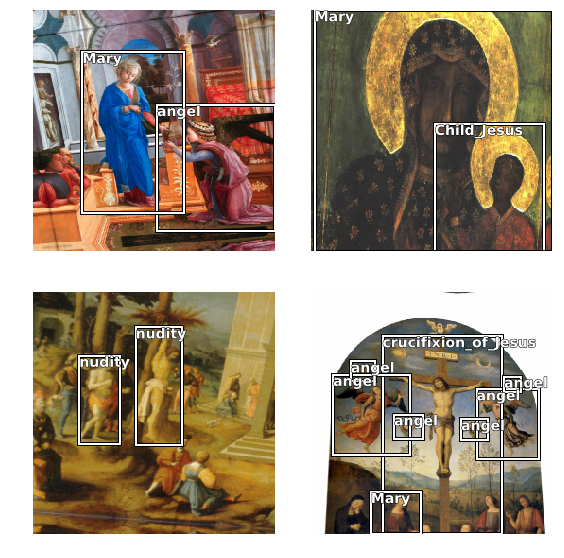

In [59]:
data.show_batch()

In [60]:
data.train_ds.classes

['background',
 'Child_Jesus',
 'Mary',
 'Saint_Sebastien',
 'angel',
 'crucifixion_of_Jesus',
 'nudity',
 'ruins']

### Train data-set 

In [61]:
anchors = create_anchors(sizes=[(32,32),(16,16),(8,8),(4,4)], ratios=[0.5, 1, 2], scales=[0.35, 0.5, 0.6, 1, 1.25, 1.6])

In [62]:
crit = RetinaNetFocalLoss(anchors)
encoder = create_body(models.resnet18, True, -2)
model = RetinaNet(encoder, n_classes=data.train_ds.c, n_anchors=18, sizes=[32,16,8,4], chs=128, final_bias=-4., n_conv=3)

In [63]:
voc = PascalVOCMetric(anchors, size, [str(i) for i in data.train_ds.y.classes[1:]])
learn = Learner(data, model, loss_func=crit, callback_fns=[BBMetrics, ShowGraph], #BBMetrics, ShowGraph
                metrics=[voc]
               )

In [64]:
learn.split([model.encoder[6], model.c5top5])
learn.freeze_to(-2)

epoch,train_loss,valid_loss,pascal_voc_metric,BBloss,focal_loss,AP-Child_Jesus,AP-Mary,AP-Saint_Sebastien,AP-angel,AP-crucifixion_of_Jesus,AP-nudity,AP-ruins,time
0,3.293597,2.782641,0,0.650505,2.132136,0,0,0,0,0,0,0,00:03


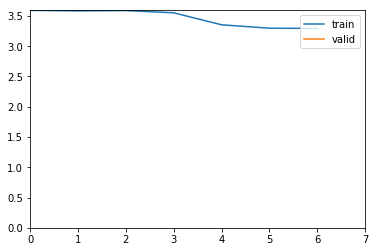

In [67]:
learn.fit_one_cycle(1, 1e-4)